# sine experiment 2

In [2]:
import argparse
import os

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from synthetic_datasets import SineSyntheticDataset

from criterions import QuantileLoss
from configuration import get_attention_hparam_grid, make_attn_module_class, get_attention_names
from sine_experiment import train, val_step, inference

## synthetic sine dataset

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

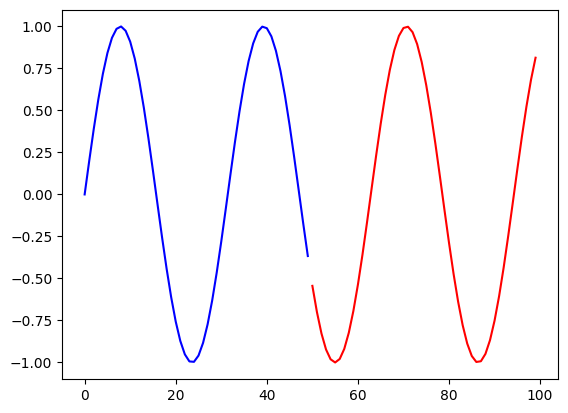

In [7]:
dataset = SineSyntheticDataset(
    len_timeseries=5000,
    seq_len=50,
    shift=50,
    alpha=0.2
)

src_x, src_y, tgt_x, tgt_y = dataset[0]

plt.plot(src_x.numpy(), src_y.numpy(), 'b')
plt.plot(tgt_x.numpy(), tgt_y.numpy(), 'r')

src_x.shape, src_y.shape, tgt_x.shape, tgt_y.shape

In [8]:
train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(3920, 490, 490, 122, 7, 7)

## Training

In [5]:
attn_names = get_attention_names()

config = argparse.Namespace()
config.quantiles = [0.1, 0.5, 0.9]
config.lr = 1e-2
config.epochs = 200
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.patience = 10
config.attn_dropout = 0.1

config.emb_size = 20
config.n_heads = 4
config.n_hidden = 32
config.ffn_n_hidden = 10

results = {}

for attn_name in attn_names[:]:
    
    attn_hparam_grid = get_attention_hparam_grid(attn_name)
    attn_module_class = make_attn_module_class(attn_name)
    
    best_model = None
    best_val_loss = float('inf')
    best_attn_hparams = None
    best_train_history, best_val_history = None, None
    
    print(f'Starting training for attention module: {attn_name}')
    
    for attn_hparams in attn_hparam_grid:
        
        attn_hparams['dropout_rate'] = config.attn_dropout
        if attn_name == 'imp':
            attn_hparams['input_size'] = config.n_hidden // config.n_heads
        
        attn_module = attn_module_class(**attn_hparams)
        model, train_history, val_history, val_loss = train(attn_module, config, train_dl, val_dl, dataset.mask, verbose=False)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            best_attn_hparams = attn_hparams
            best_train_history = train_history
            best_val_history = val_history
            
        print(f'\t{attn_hparams=}, {val_loss=:.4f}, {best_val_loss=:.4f}')
    
    criterion = QuantileLoss(config).to(config.device)
    test_loss = val_step(best_model, criterion, test_dl, dataset.mask, config.device).cpu()    
    results[attn_name] = {
        'attn_name': attn_name, 
        'test_loss': test_loss, 
        'best_model': best_model, 
        'best_attn_params': best_attn_hparams,
        'best_train_history': best_train_history, 
        'best_val_history': best_val_history
    }

Starting training for attention module: sdp
	attn_hparams={'dropout_rate': 0.1}, val_loss=0.1501, best_val_loss=0.1501
Starting training for attention module: lin
	attn_hparams={'dropout_rate': 0.1}, val_loss=0.1357, best_val_loss=0.1357
Starting training for attention module: exp
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 1, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.1288, best_val_loss=0.1288
	attn_hparams={'p_norm_sim': 2, 'p_norm_mag': 1, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.1440, best_val_loss=0.1288
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 2, 'include_magnitude': True, 'dropout_rate': 0.1}, val_loss=0.1345, best_val_loss=0.1288
	attn_hparams={'p_norm_sim': 1, 'p_norm_mag': 0, 'include_magnitude': False, 'dropout_rate': 0.1}, val_loss=0.1217, best_val_loss=0.1217
	attn_hparams={'p_norm_sim': 2, 'p_norm_mag': 0, 'include_magnitude': False, 'dropout_rate': 0.1}, val_loss=0.1415, best_val_loss=0.1217
Starting training for attention modu

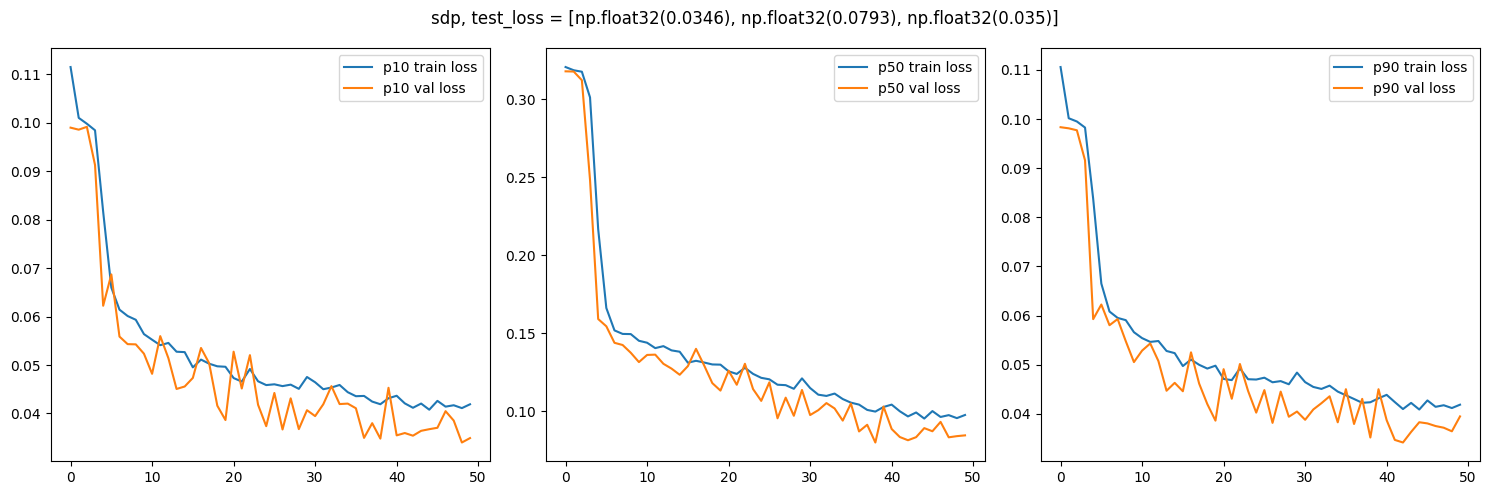

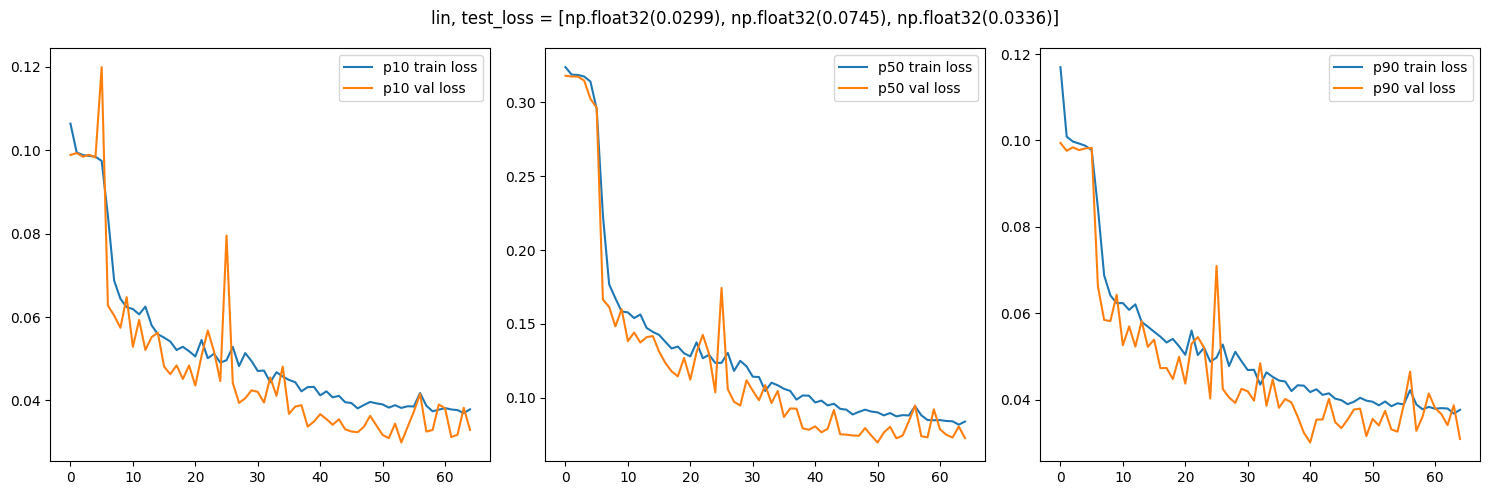

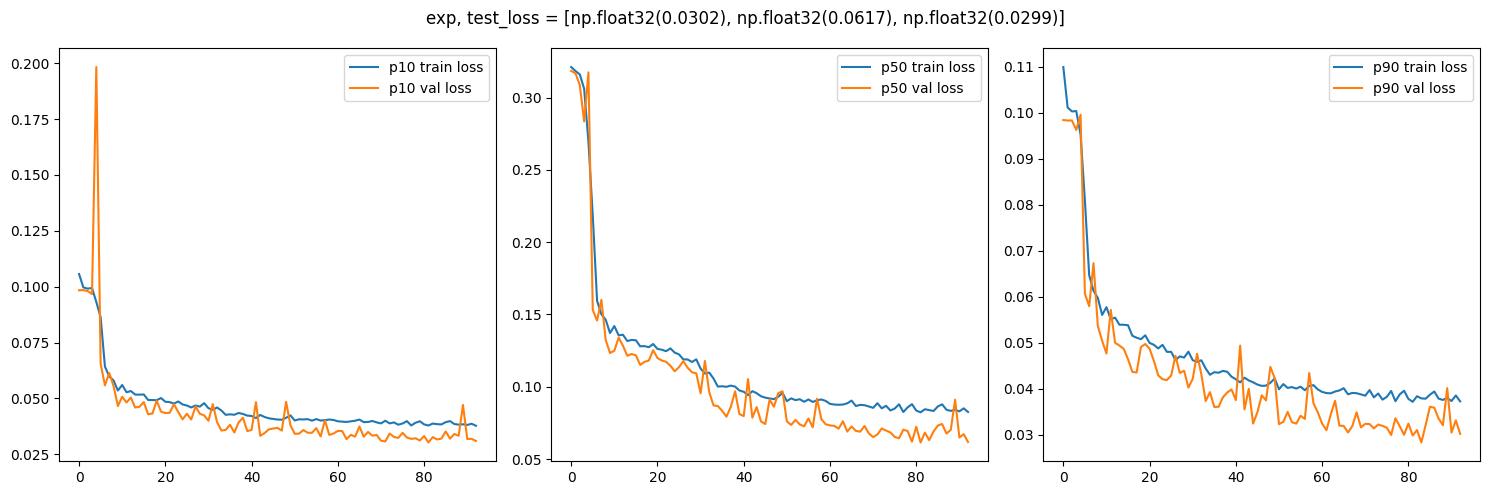

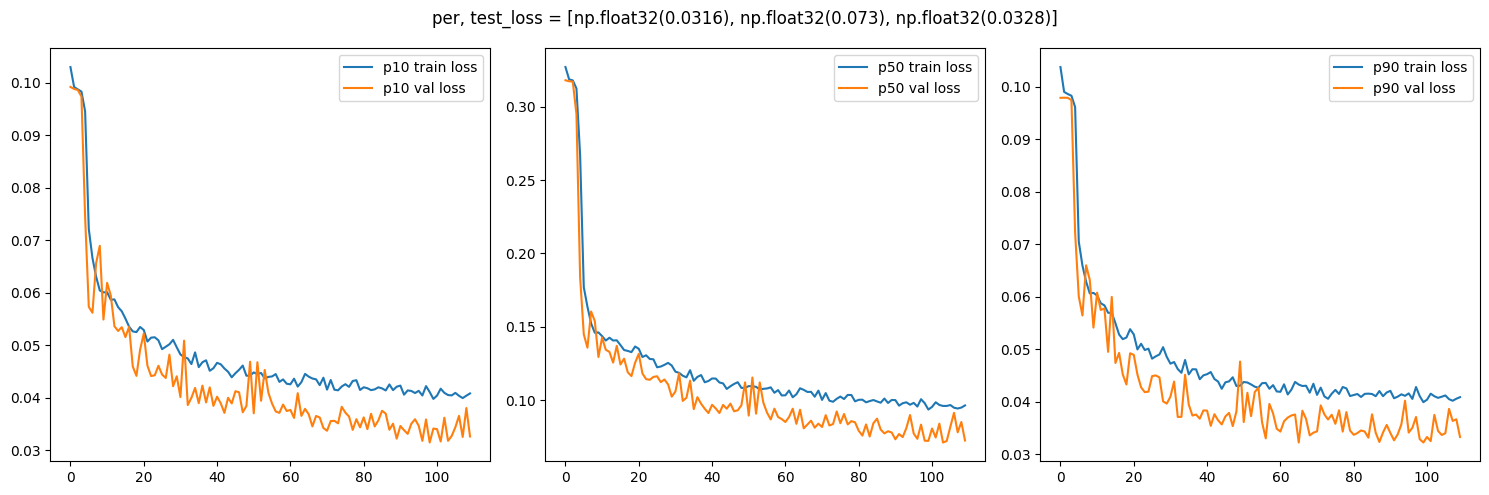

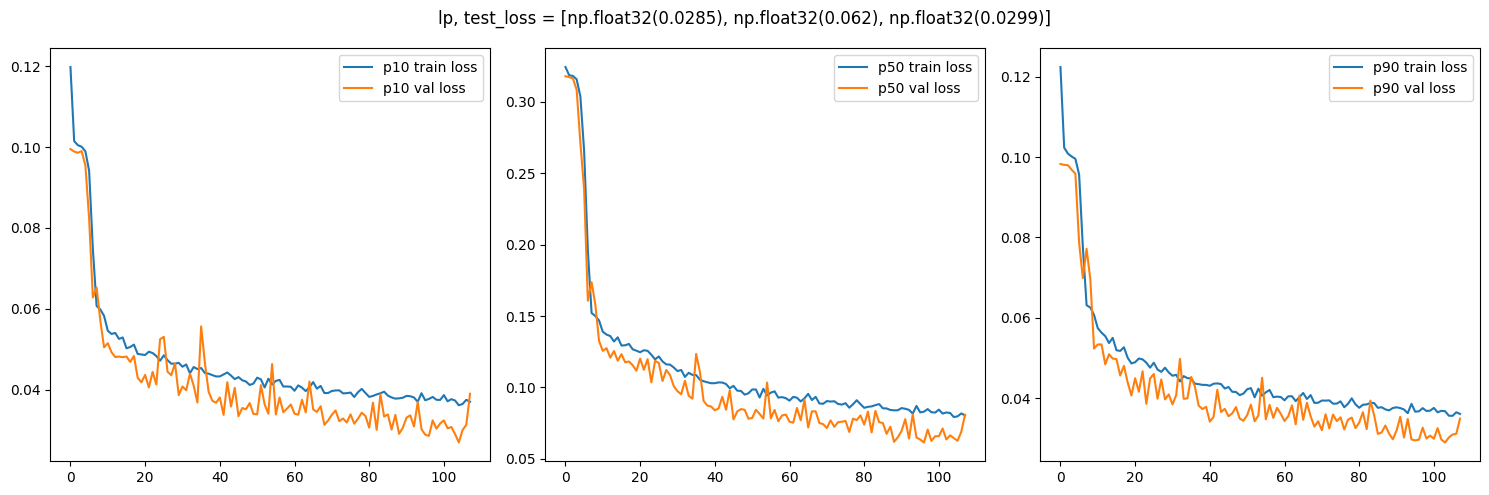

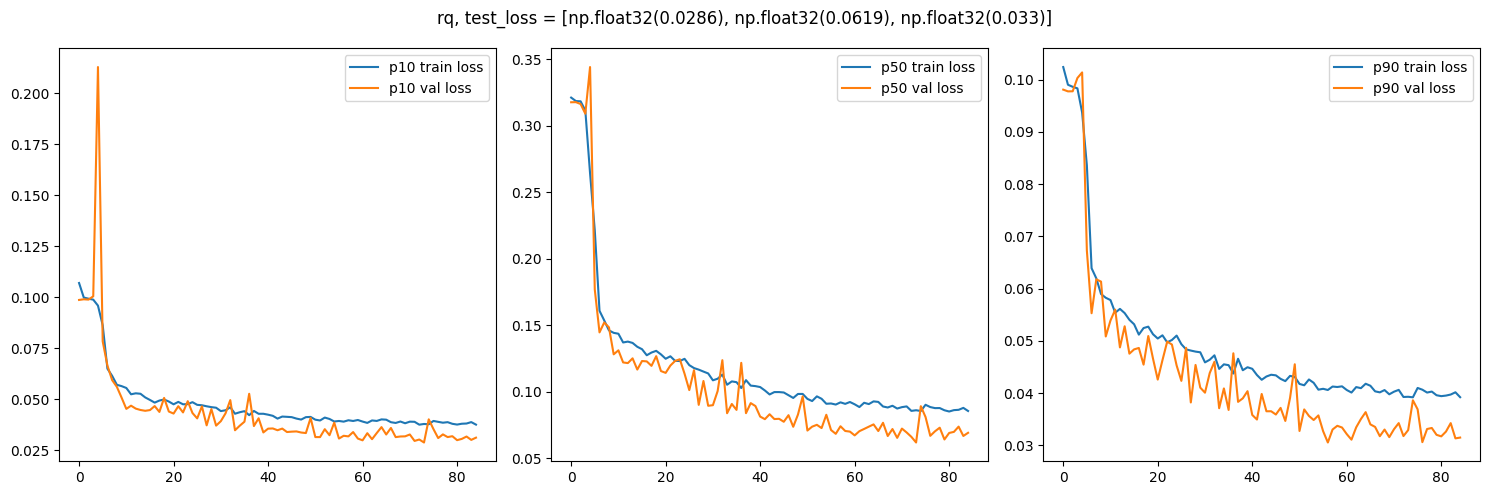

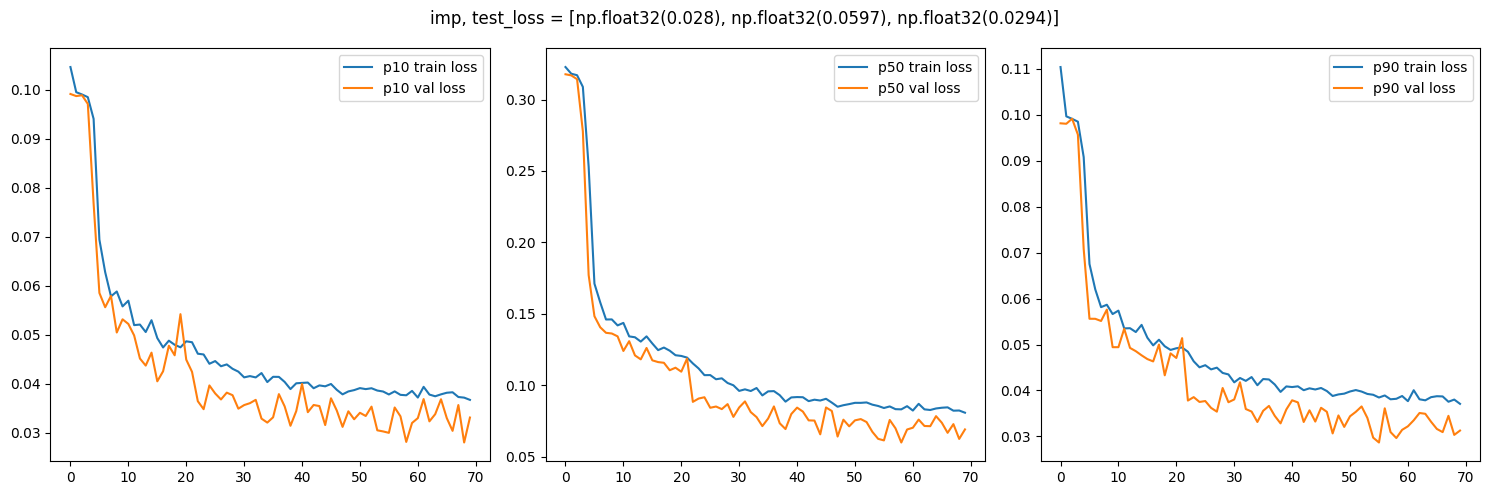

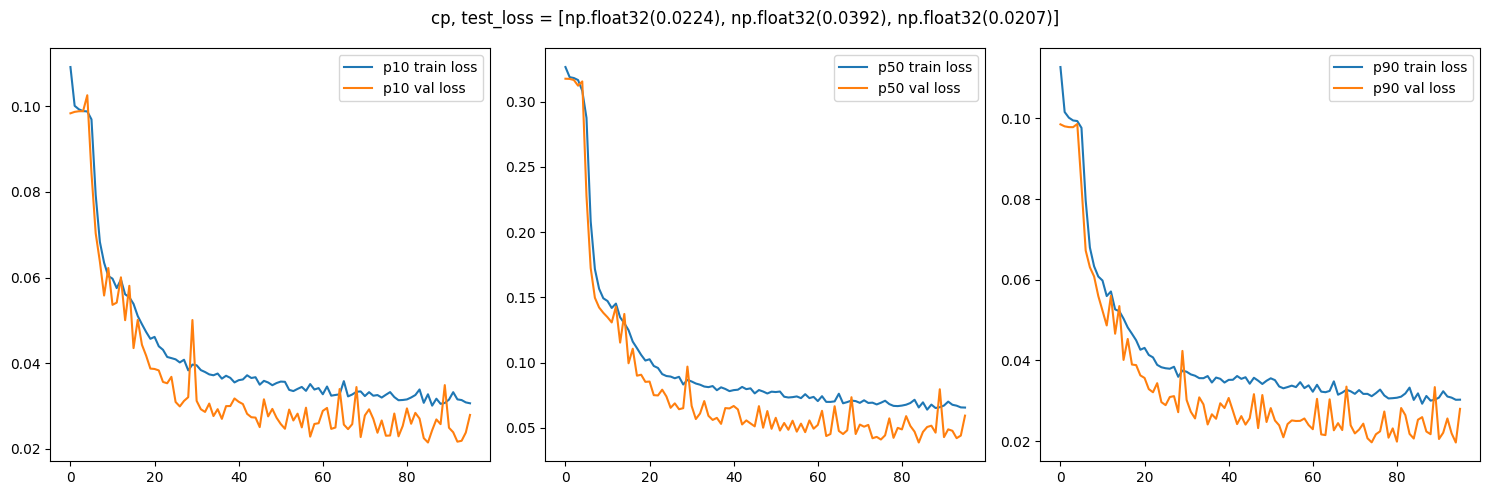

In [6]:
for name, exp in results.items():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
    
    train_history = exp['best_train_history']
    val_history = exp['best_val_history']
    
    p10_train = [x['p10'] for x in train_history]
    p50_train = [x['p50'] for x in train_history]
    p90_train = [x['p90'] for x in train_history]
    
    p10_val = [x['p10'] for x in val_history]
    p50_val = [x['p50'] for x in val_history]
    p90_val = [x['p90'] for x in val_history]
    
    ax1.plot(p10_train, label='p10 train loss')
    ax1.plot(p10_val, label='p10 val loss')
    ax1.legend()
    
    ax2.plot(p50_train, label='p50 train loss')
    ax2.plot(p50_val, label='p50 val loss')
    ax2.legend()
    
    ax3.plot(p90_train, label='p90 train loss')
    ax3.plot(p90_val, label='p90 val loss')
    ax3.legend()
    
    fig.suptitle(f'{exp["attn_name"]}, test_loss = {[round(q, 4) for q in exp["test_loss"].numpy()]}')
    
    plt.tight_layout()
    plt.show()

## Inference

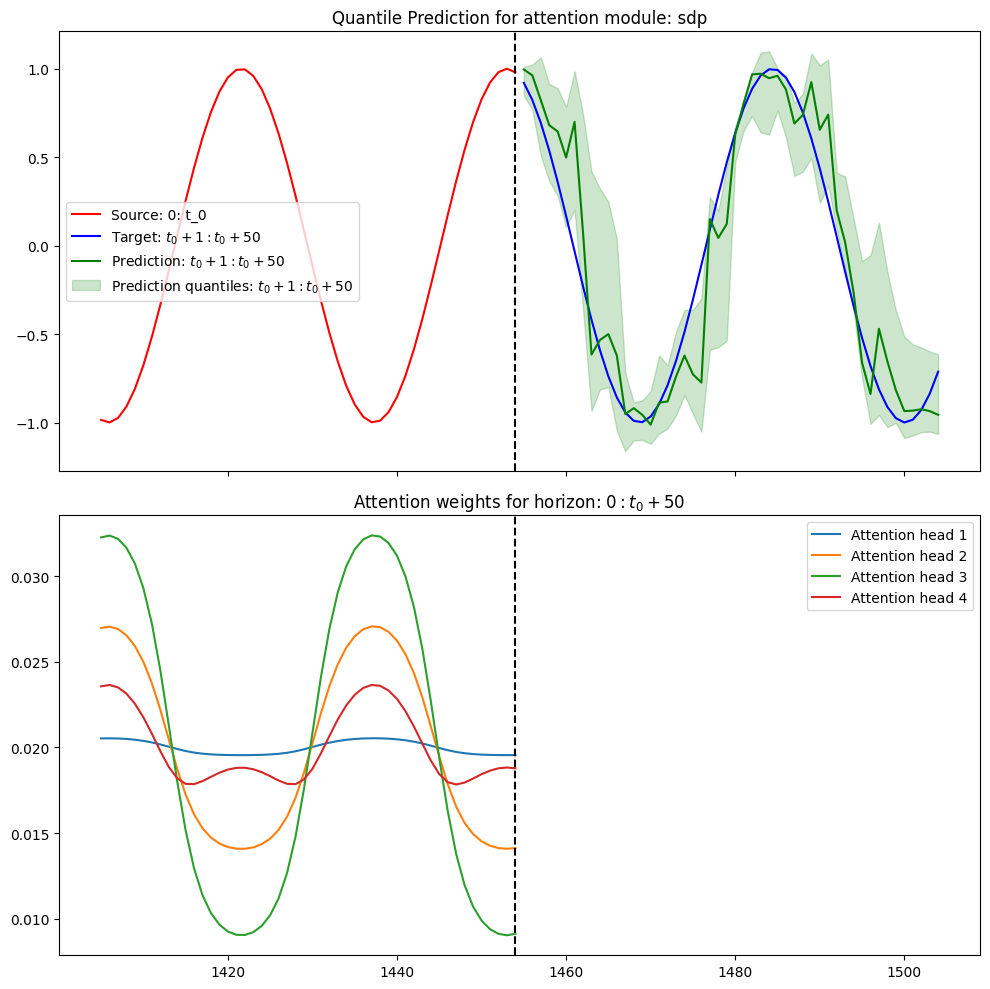

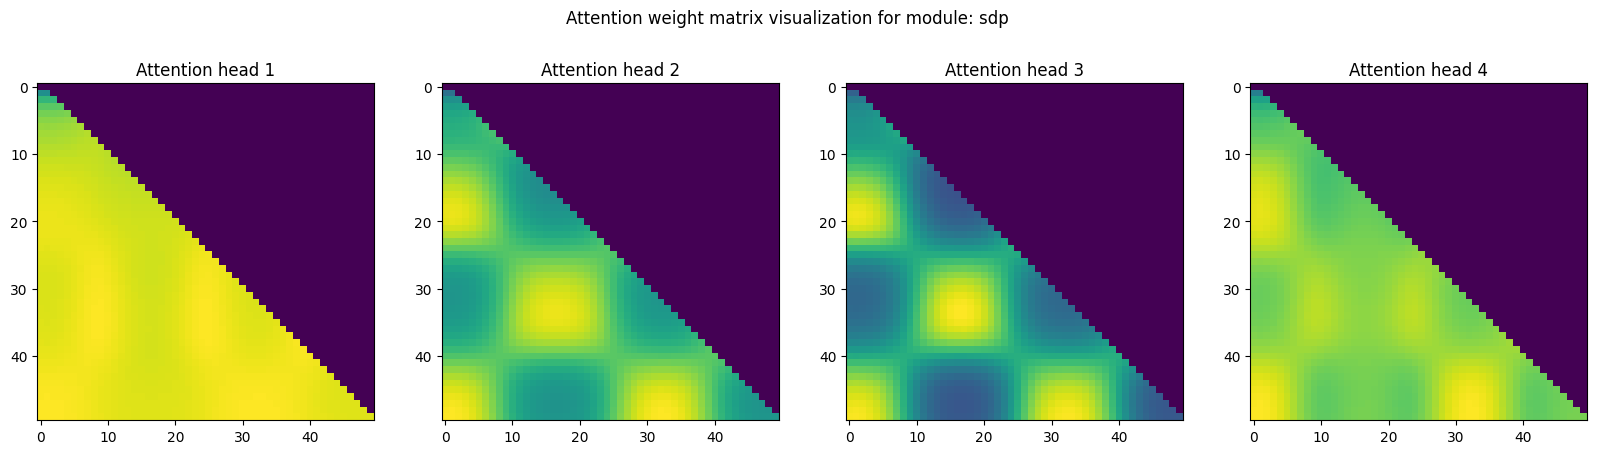

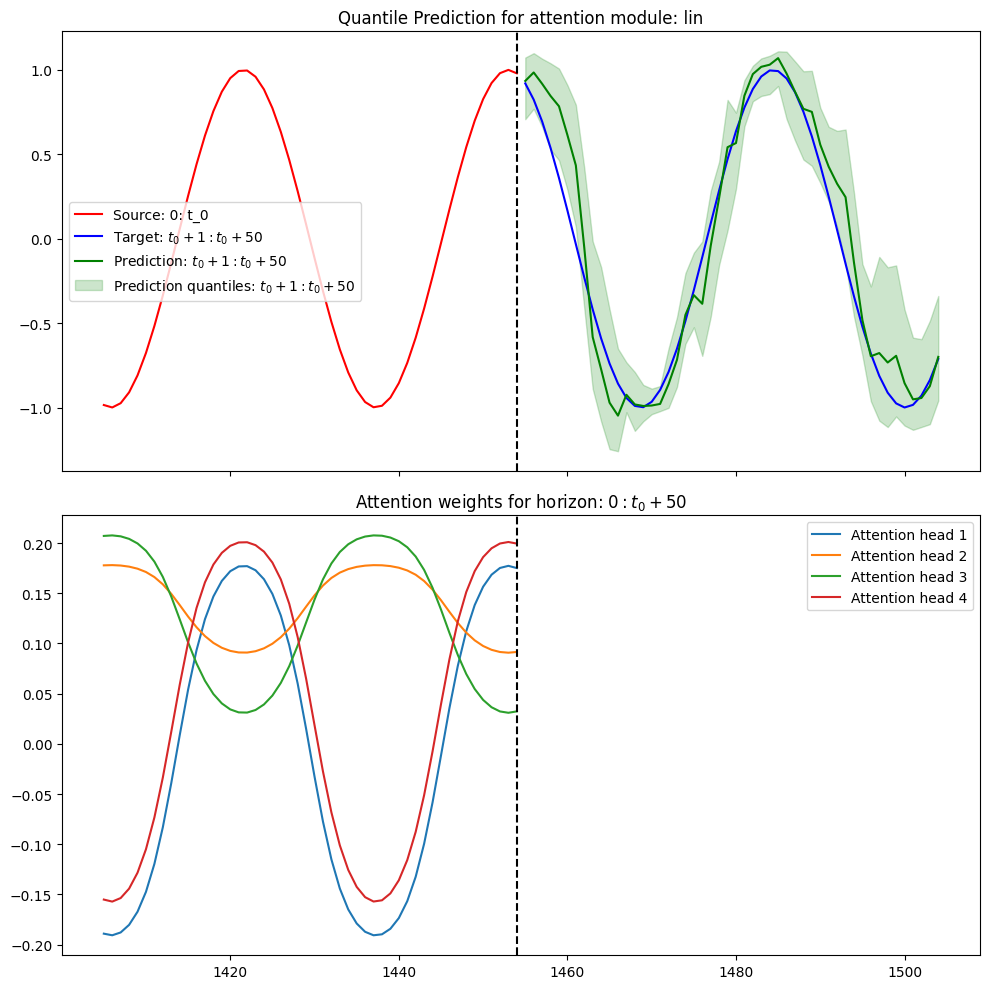

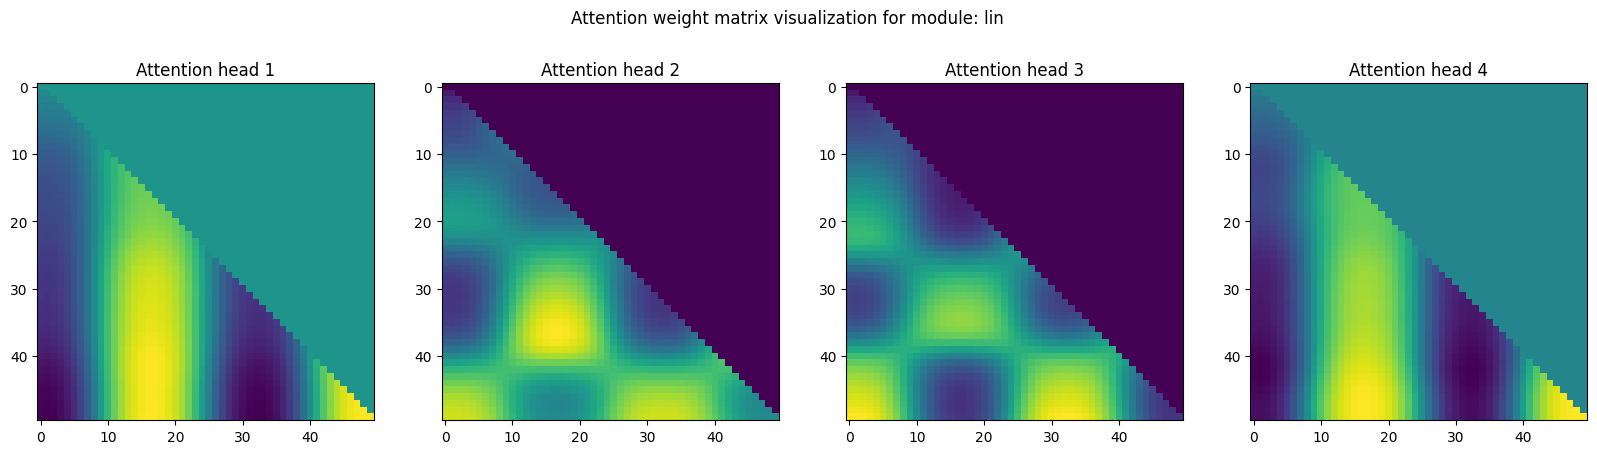

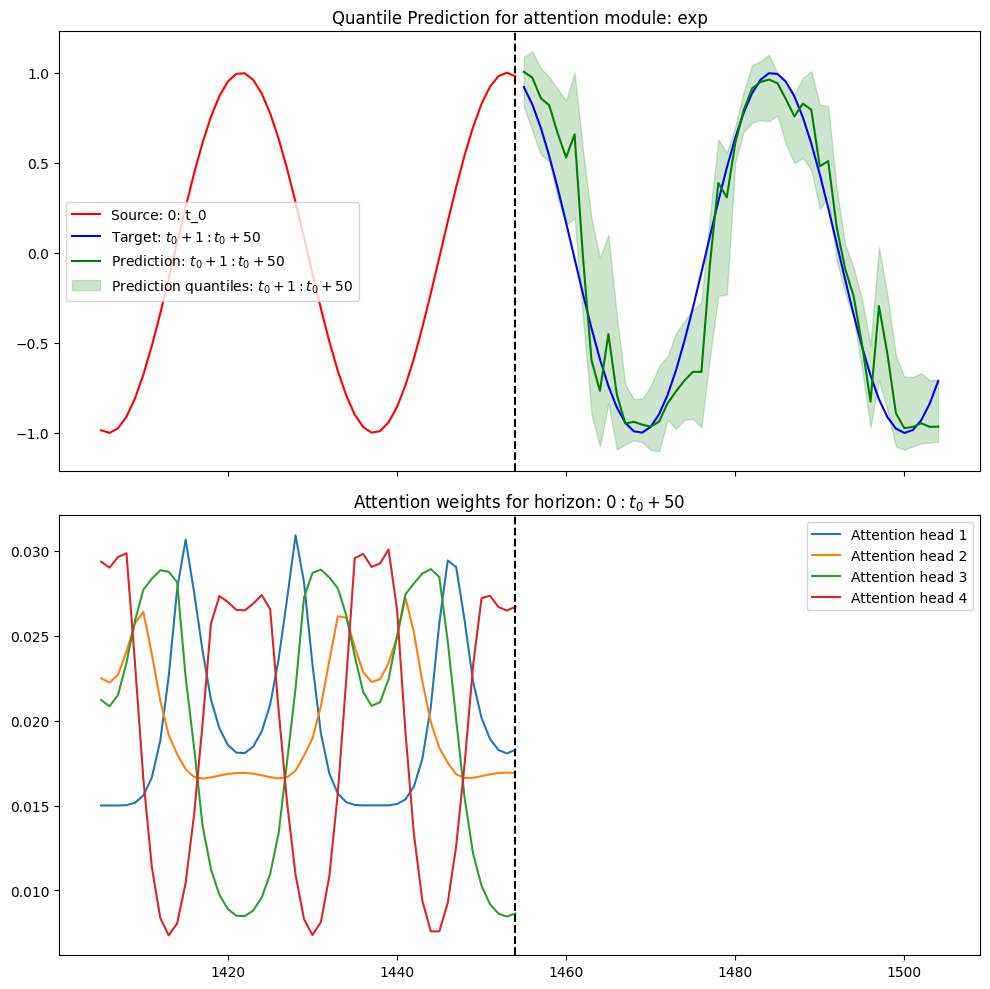

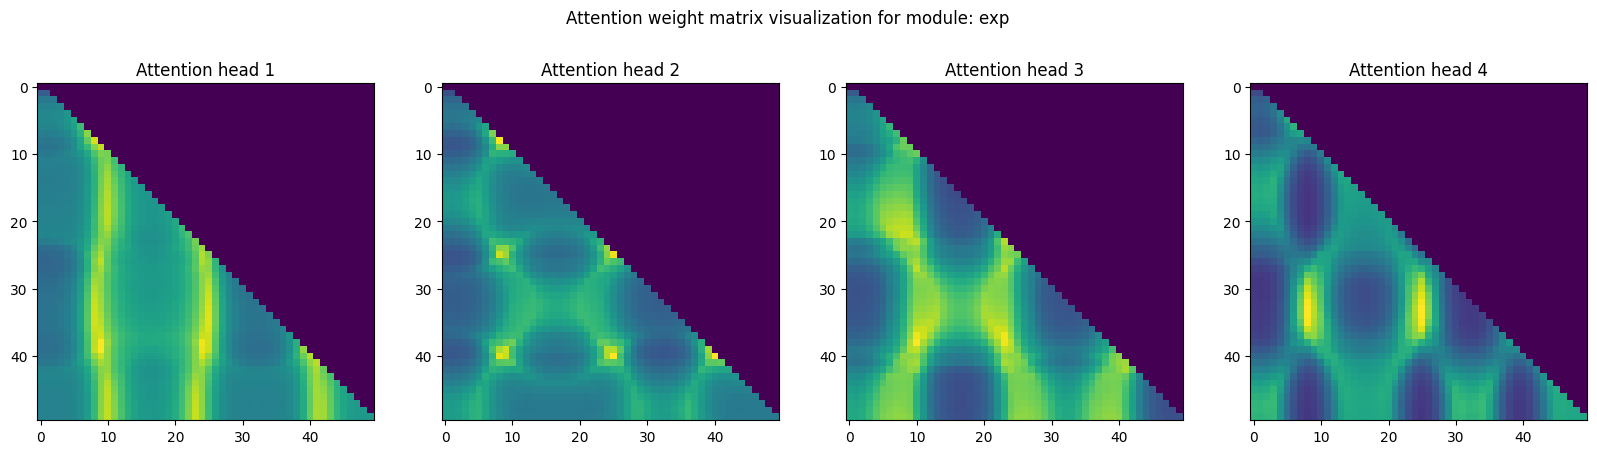

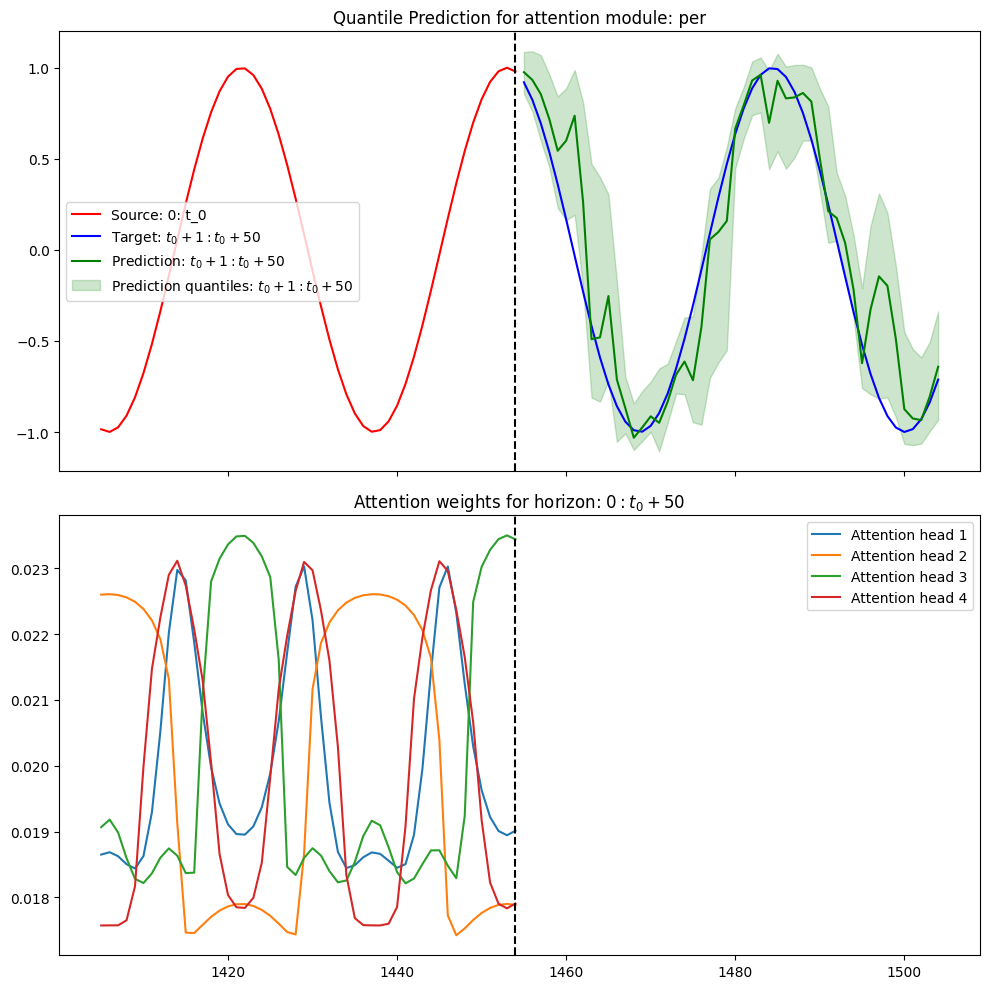

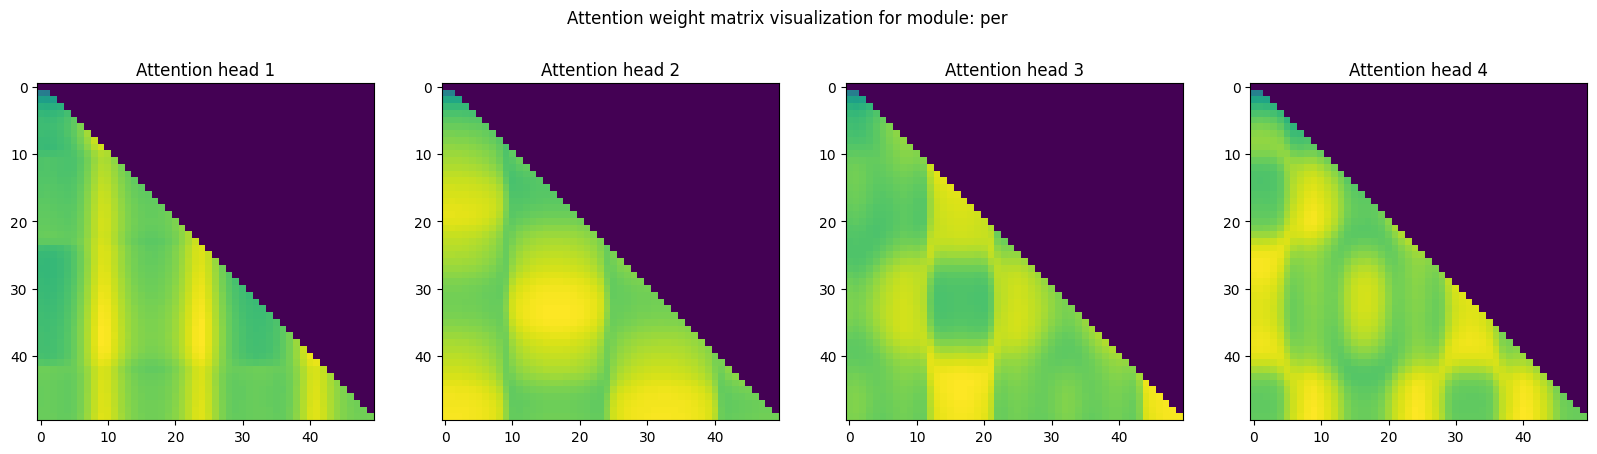

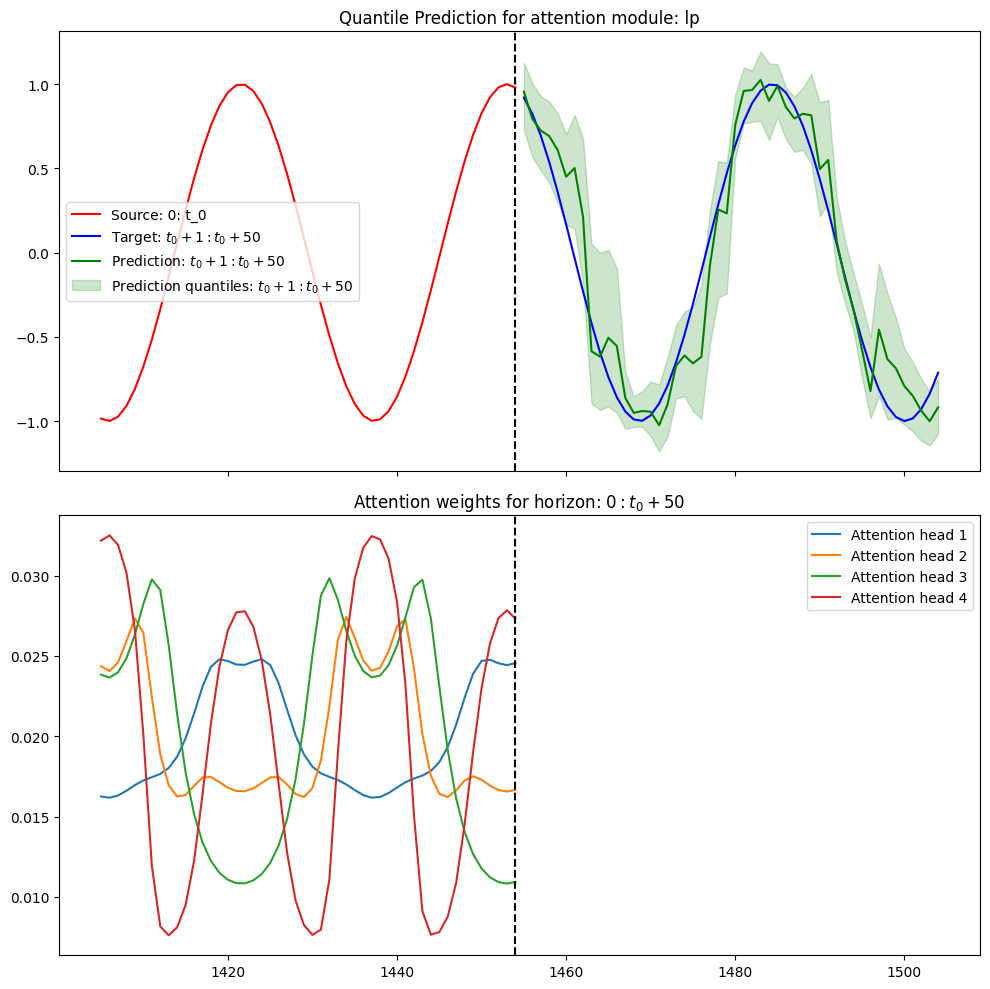

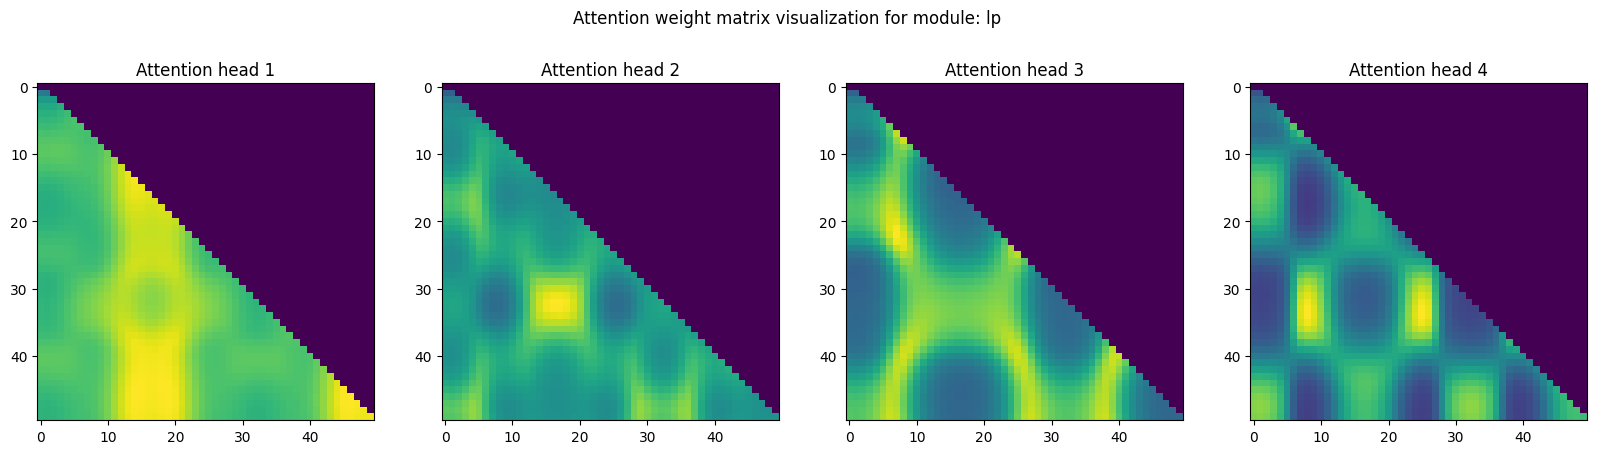

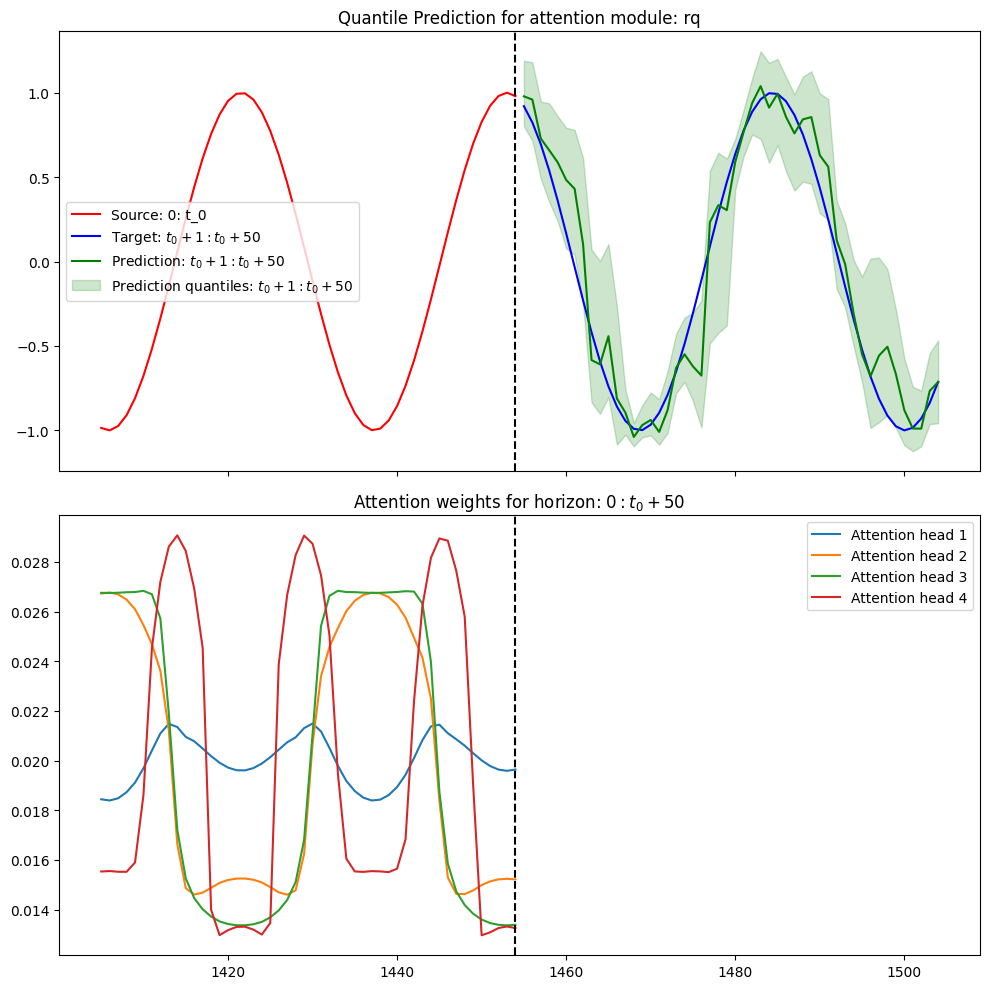

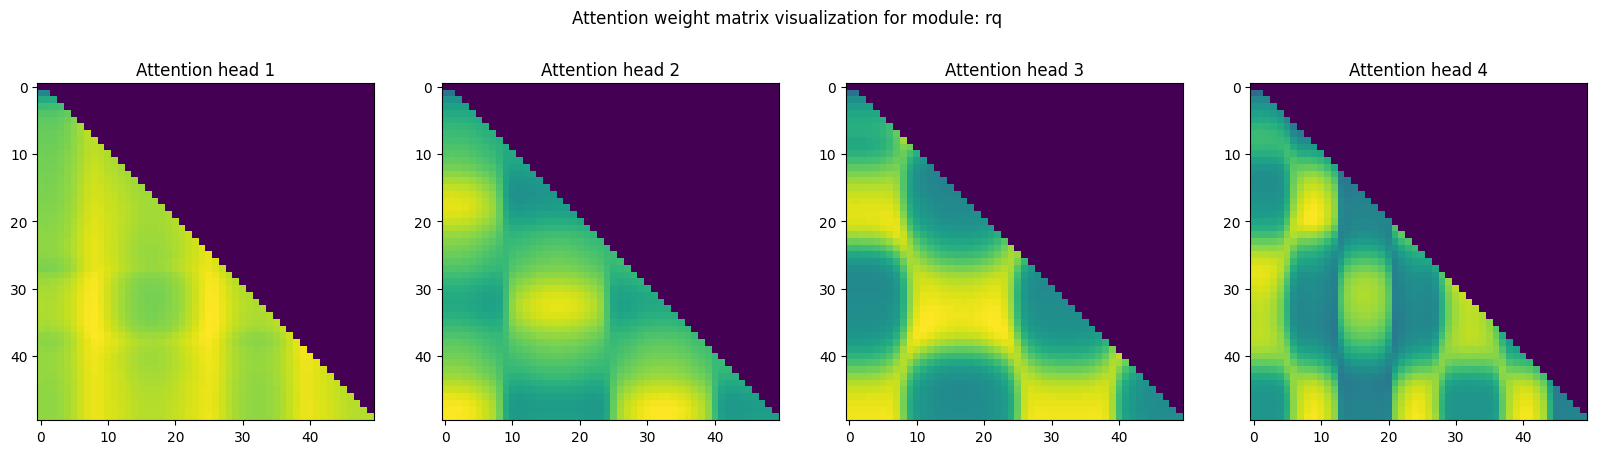

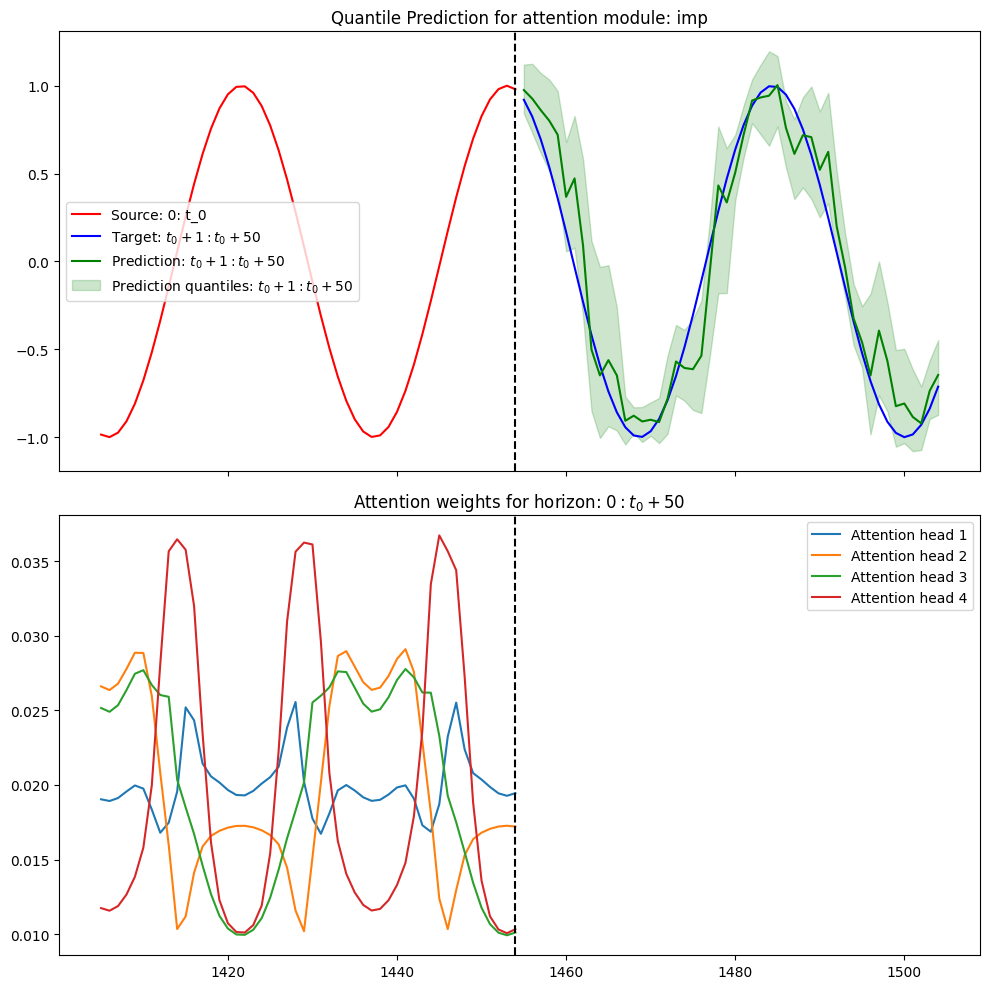

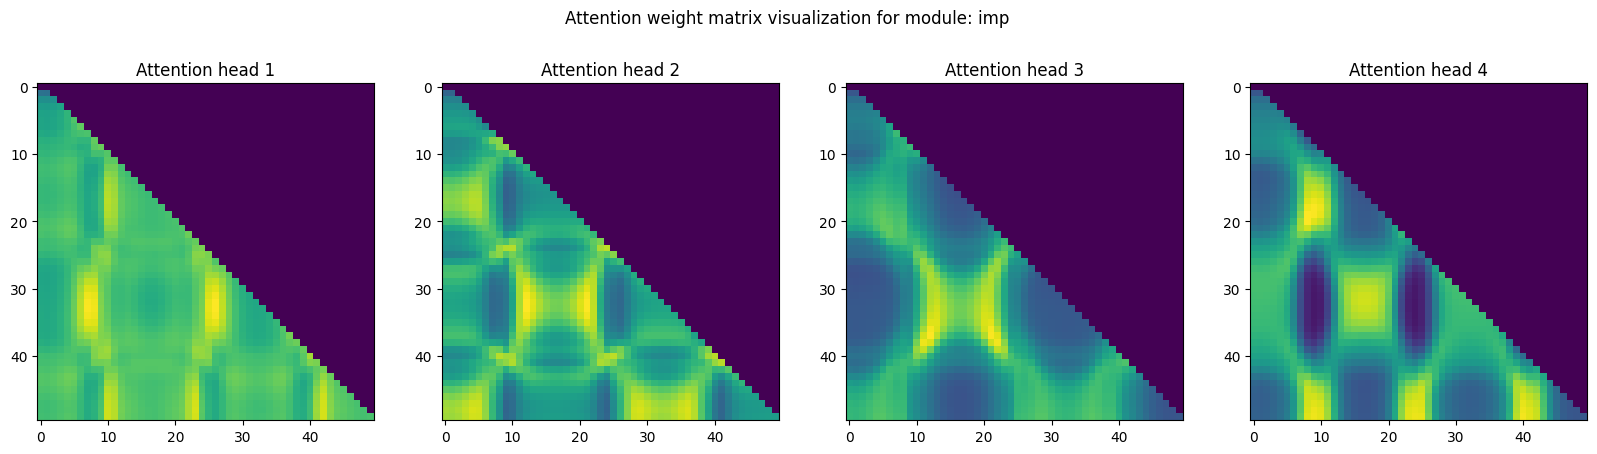

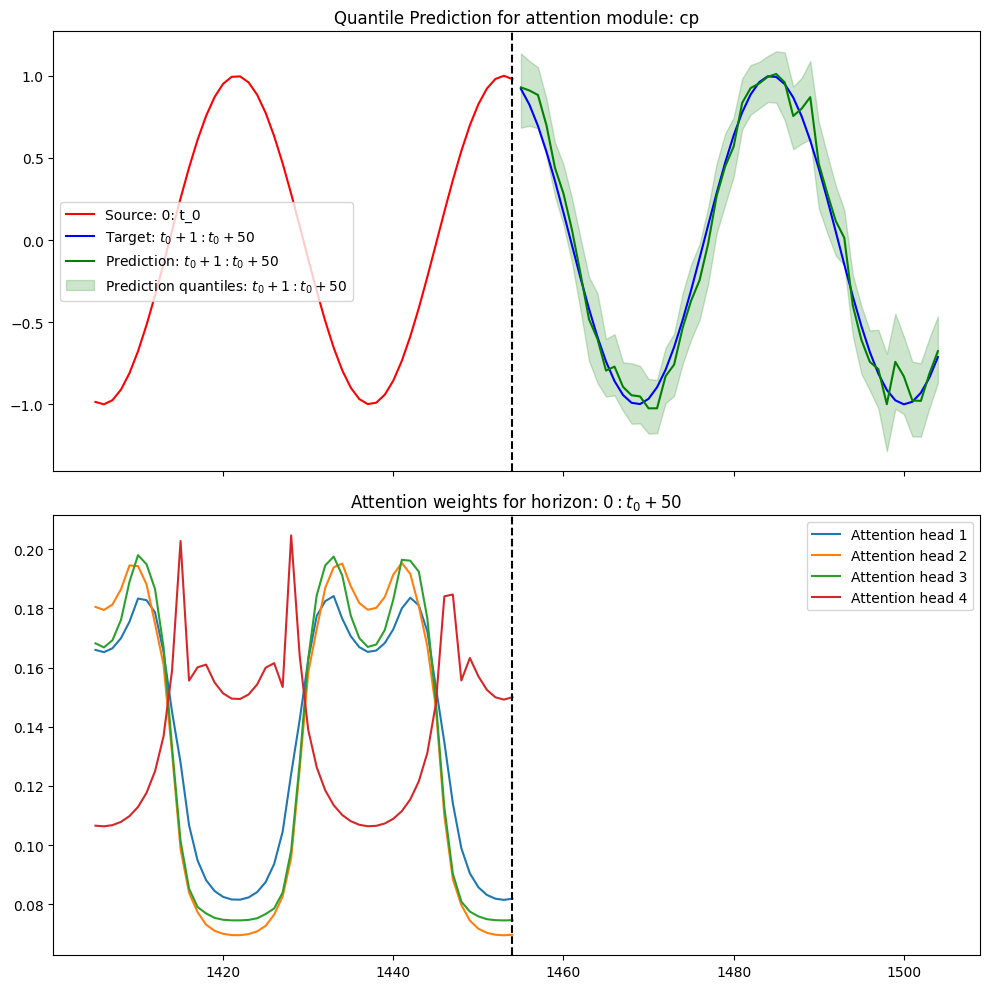

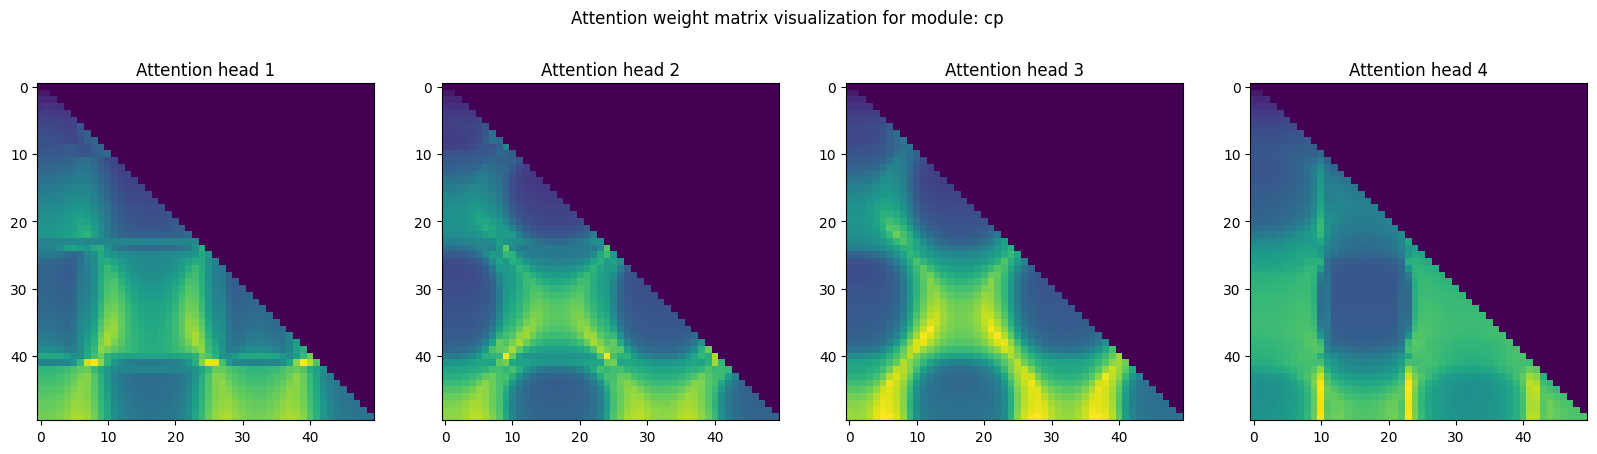

In [7]:
idx = 15

for name, exp in results.items():
    
    best_model = exp['best_model']
    attn_name = exp['attn_name']
    
    inference(idx, best_model, test_set, config, dataset.mask, attn_name)

In [10]:
for name, exp in results.items():
    
    print(name, exp['test_loss'])

sdp tensor([0.0346, 0.0793, 0.0350])
lin tensor([0.0299, 0.0745, 0.0336])
exp tensor([0.0302, 0.0617, 0.0299])
per tensor([0.0316, 0.0730, 0.0328])
lp tensor([0.0285, 0.0620, 0.0299])
rq tensor([0.0286, 0.0619, 0.0330])
imp tensor([0.0280, 0.0597, 0.0294])
cp tensor([0.0224, 0.0392, 0.0207])


In [8]:
results_path = os.path.join('results_sine_exp2')

os.makedirs(results_path, exist_ok=True)

In [9]:
for name, exp in results.items():
    ckpt = {
        'name': name, 
        'config': config, 
        'model': exp['best_model'].state_dict(), 
        'attn_name': exp['attn_name'], 
        'test_loss': exp['test_loss'], 
        'best_model': exp['best_model'], 
        'best_attn_params': exp['best_attn_params']
    }
    
    torch.save(ckpt, os.path.join(results_path, f'{name}_checkpoint.pt'))

## Analysis

In [9]:
results_path = os.path.join('results_sine_exp2')

ckpts = [os.path.join(results_path, ckpt_path) for ckpt_path in os.listdir(results_path)]

models = {}
config = {}

for ckpt in ckpts:
    state_dict = torch.load(ckpt, weights_only=False)
    
    # attn_module_class = make_attn_module_class(state_dict['attn_name'])
    # attn_module = attn_module_class(**state_dict['best_attn_params'])
    # model = create_model(attn_module, state_dict['config'])
    # model.load_state_dict(state_dict['model'])
    model = state_dict['best_model']
    
    models[state_dict['name']] = model
    config[state_dict['name']] = state_dict['config']

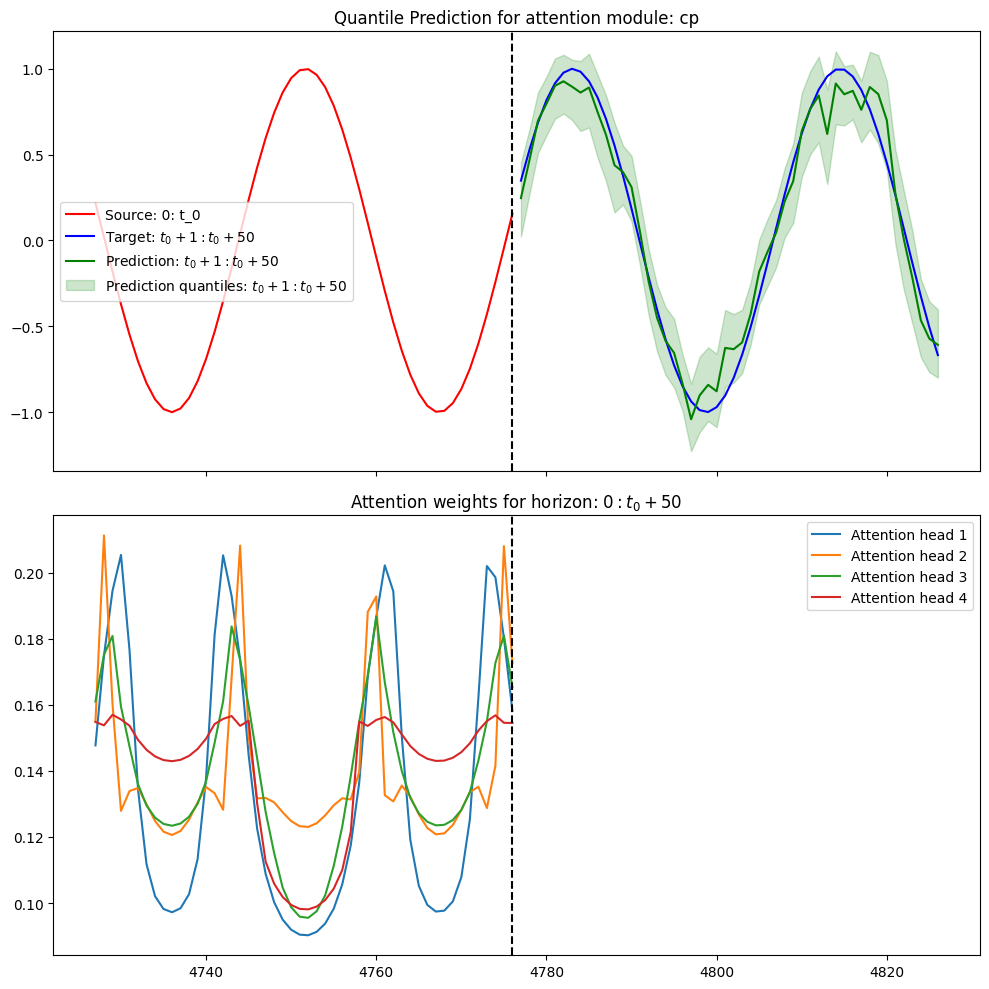

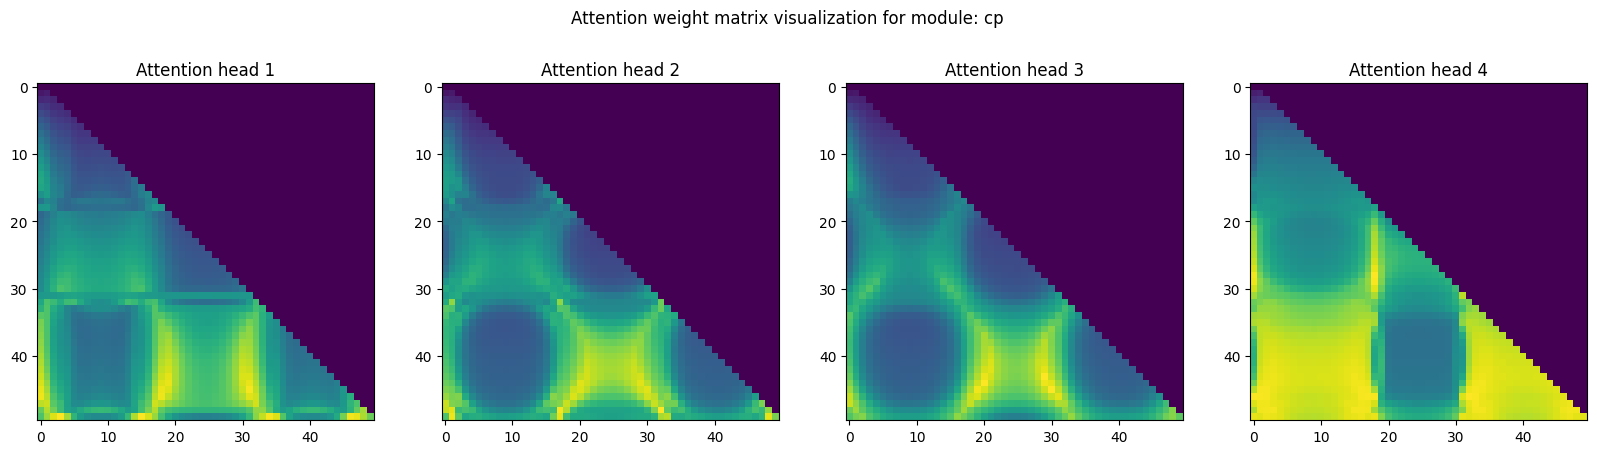

In [10]:
inference(15, models['cp'], test_set, config['cp'], dataset.mask, 'cp')

In [25]:
features = {} #dictionary that will store results!

def get_features(name):
    features[name] = []
    def hook(model, input, output):
        features[name].append(output.detach())
        # features[name] = output.detach()
    return hook

hook_handles = []

In [24]:
for handle in hook_handles:
    handle.remove()

In [12]:
hook_handles.append(models['cp'].pos_enc.register_forward_hook(get_features("pre_attn_emb")))
hook_handles.append(models['cp'].transformer_blocks[0].mha.W_v.register_forward_hook(get_features("attn_V")))

In [13]:
hook_handles

In [15]:
criterion = QuantileLoss(config['cp']).to(config['cp'].device)

test_loss = val_step(models['cp'], criterion, test_dl, dataset.mask, config['cp'].device)

'cp'

[0.5398181 0.9958044 1.       ]
[0.5401092 0.9965769 0.9988636]
[0.96167874 0.9832514  1.0000001 ]
[0.5377206  0.99283284 0.99589777]
[0.8054054  0.9146604  0.99999994]
[0.5042336  0.93338954 0.9616679 ]
[0.5232631 0.9721312 1.       ]
[0.43088233 0.80170906 0.8992517 ]
[0.99837834 0.9992891  0.99999994]
[0.33664072 0.63159037 0.81378376]
[0.427262  0.8267379 1.       ]
[0.53365844 0.98368573 0.9886254 ]
[0.44967315 0.8576491  1.        ]
[0.5359842 0.9883807 0.9929558]
[0.96867144 0.986248   1.        ]
[0.510117   0.9476408  0.98555094]
[0.5397365  0.9966332  0.99763983]
[0.53995854 0.996024   0.99748605]
[0.6374618  0.98604167 0.990159  ]
[0.5299776 0.980688  0.991799 ]
[0.51671535 0.9576678  0.97741514]
[0.5748039  0.77795106 0.9370719 ]
[0.46119267 0.8427421  0.9190791 ]
[0.5229613  0.96364105 0.97644347]
[0.70059717 0.94813555 0.9805106 ]
[0.5354529 0.9857011 0.9904629]
[0.5363898  0.99282885 0.9948653 ]
[0.6600233  0.9688879  0.97652155]
[0.459556   0.85310274 0.9241508 ]
[0.306

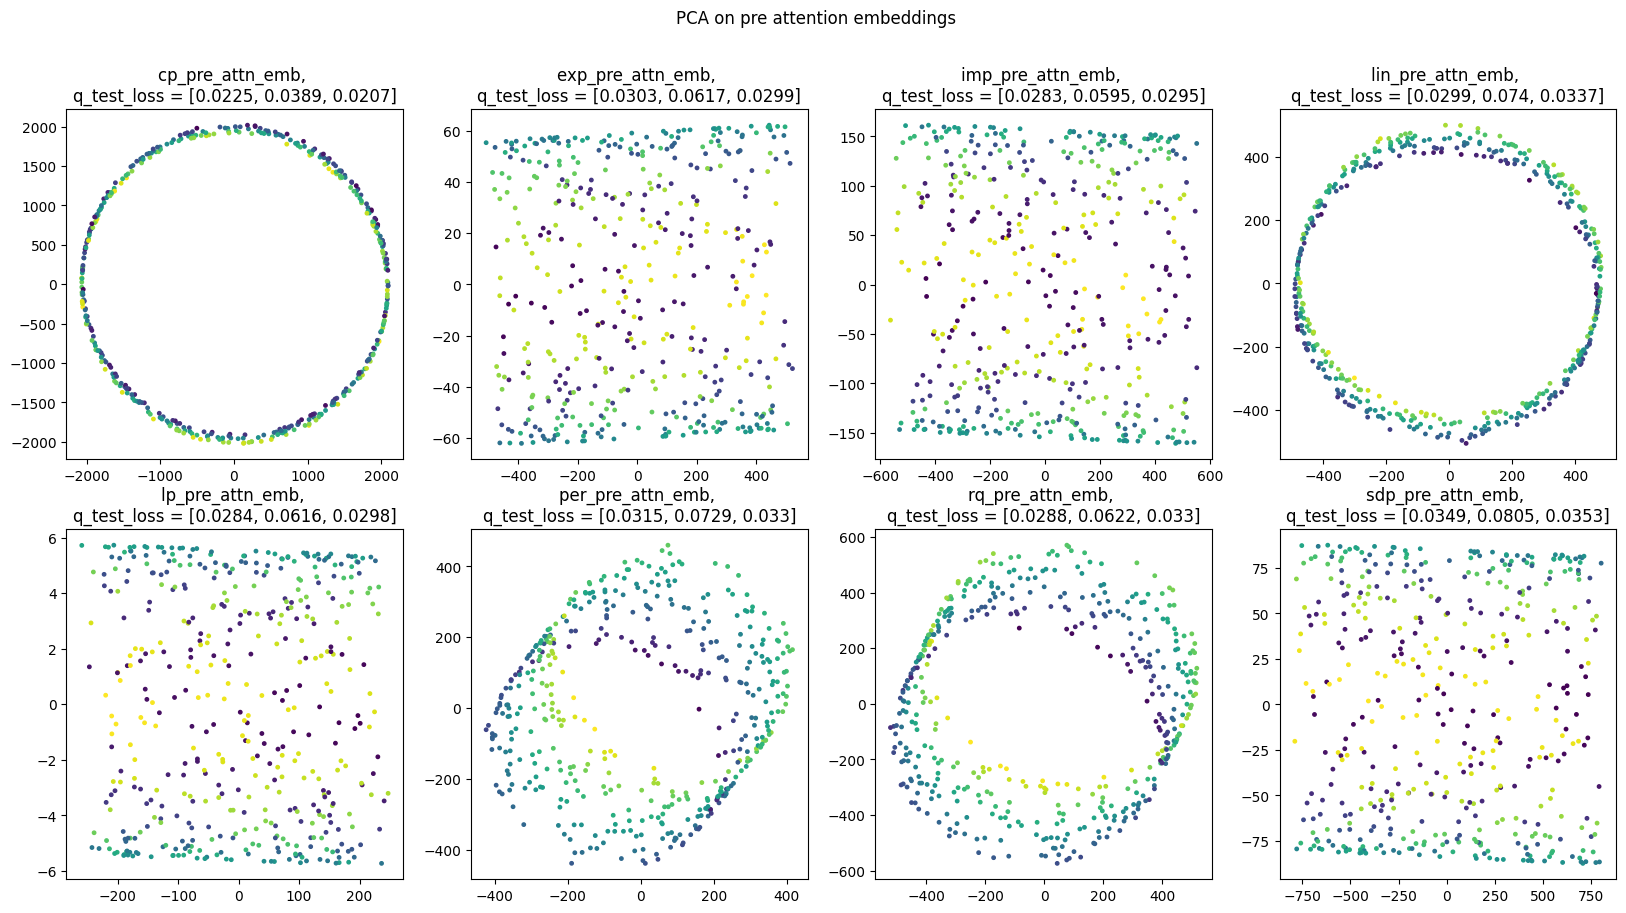

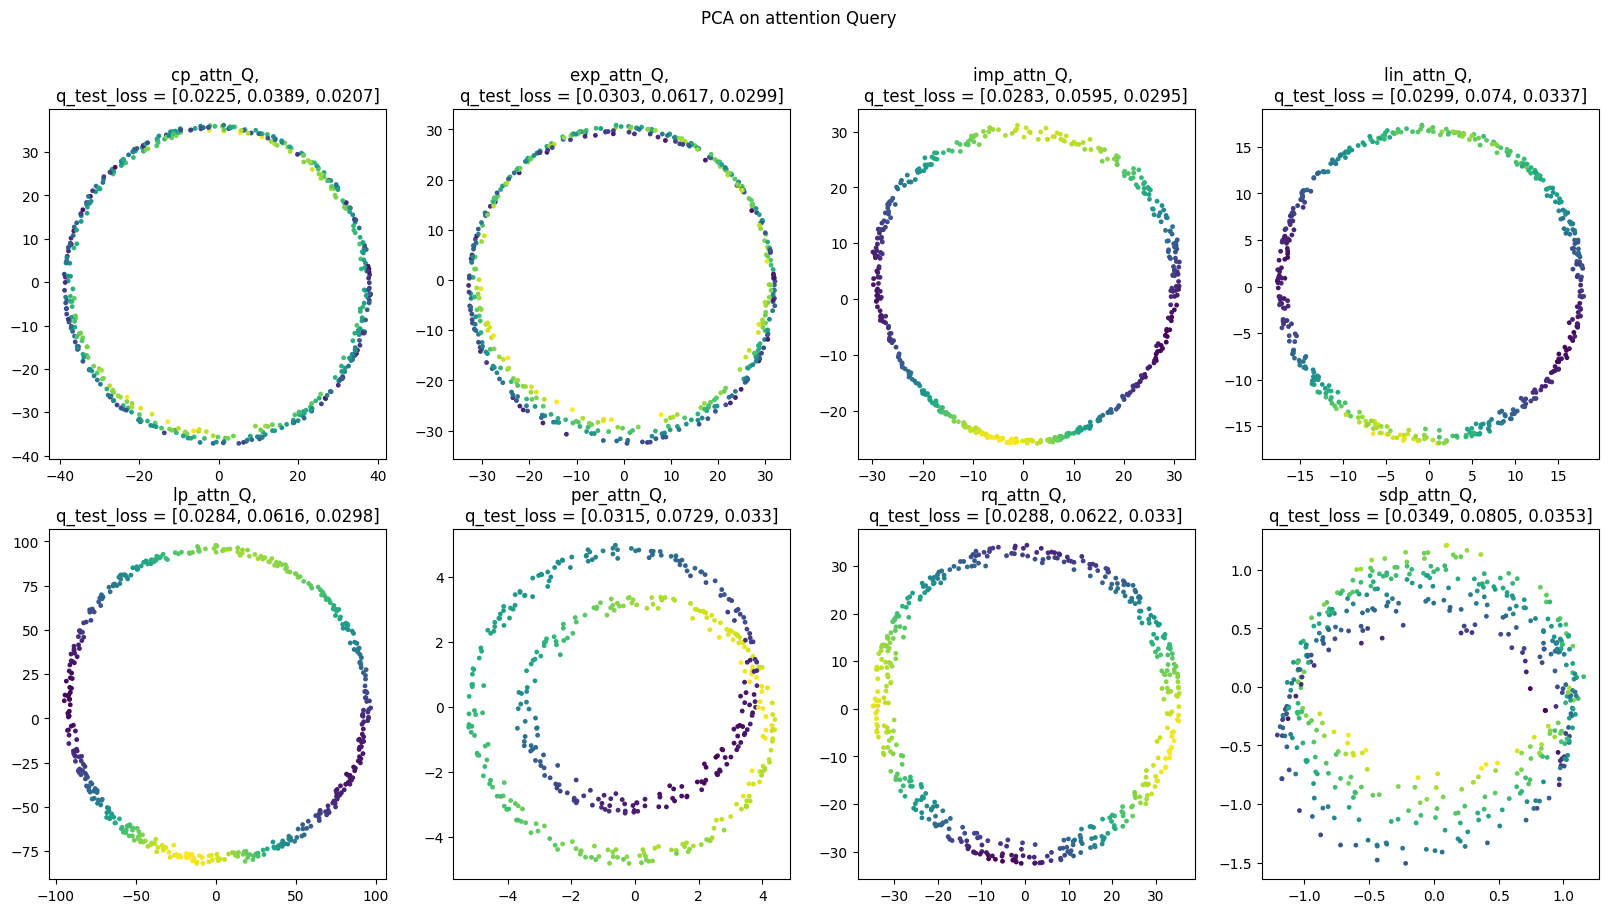

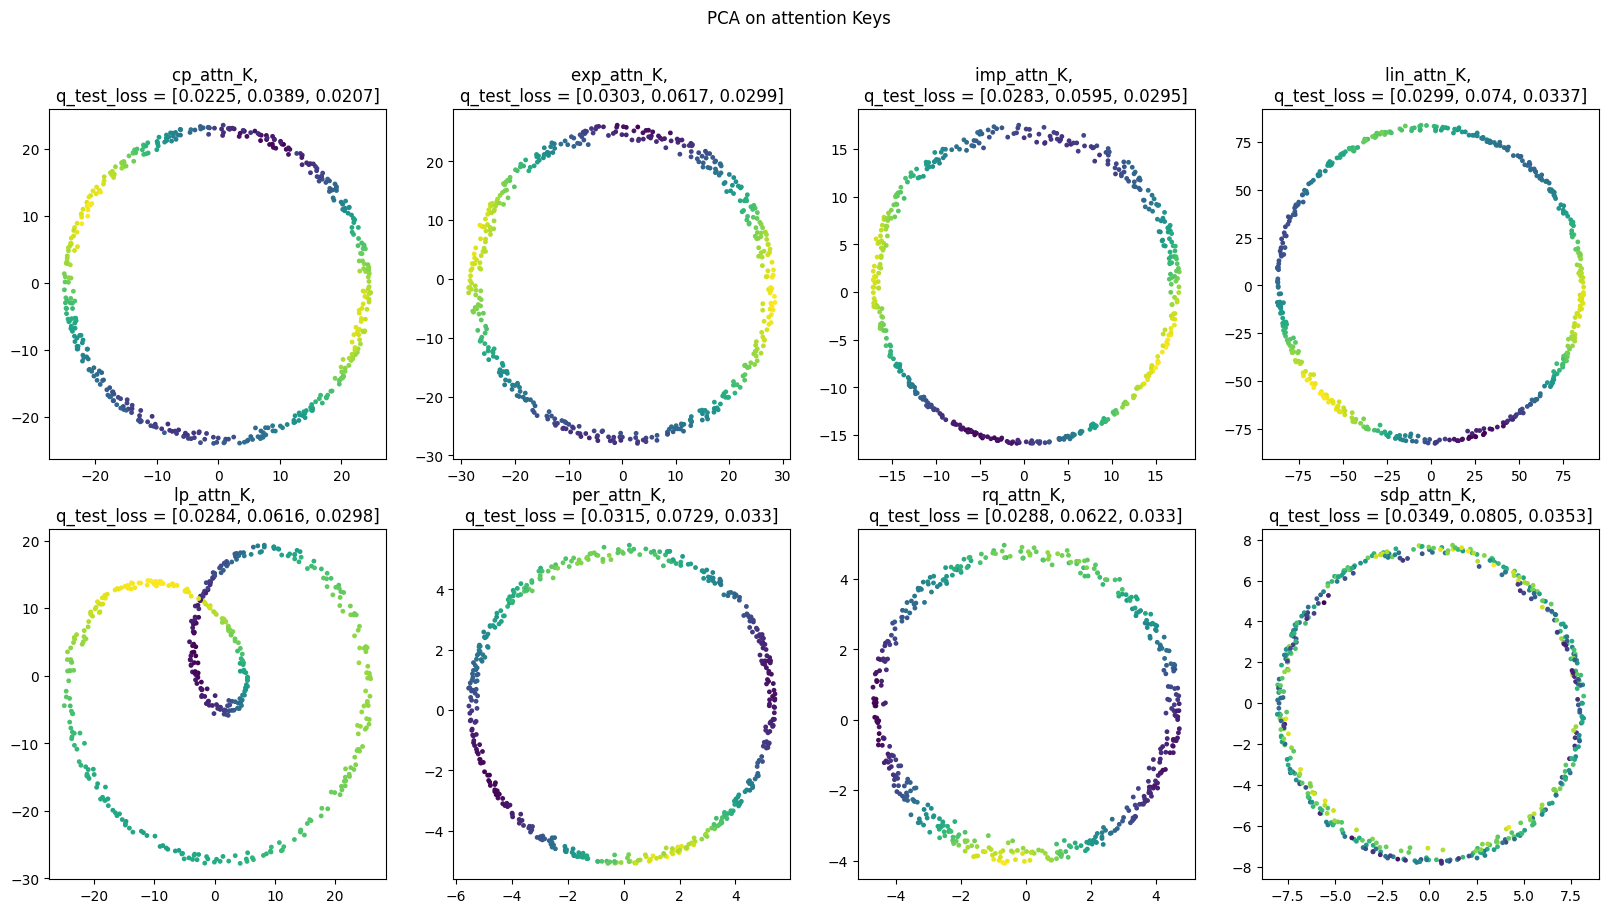

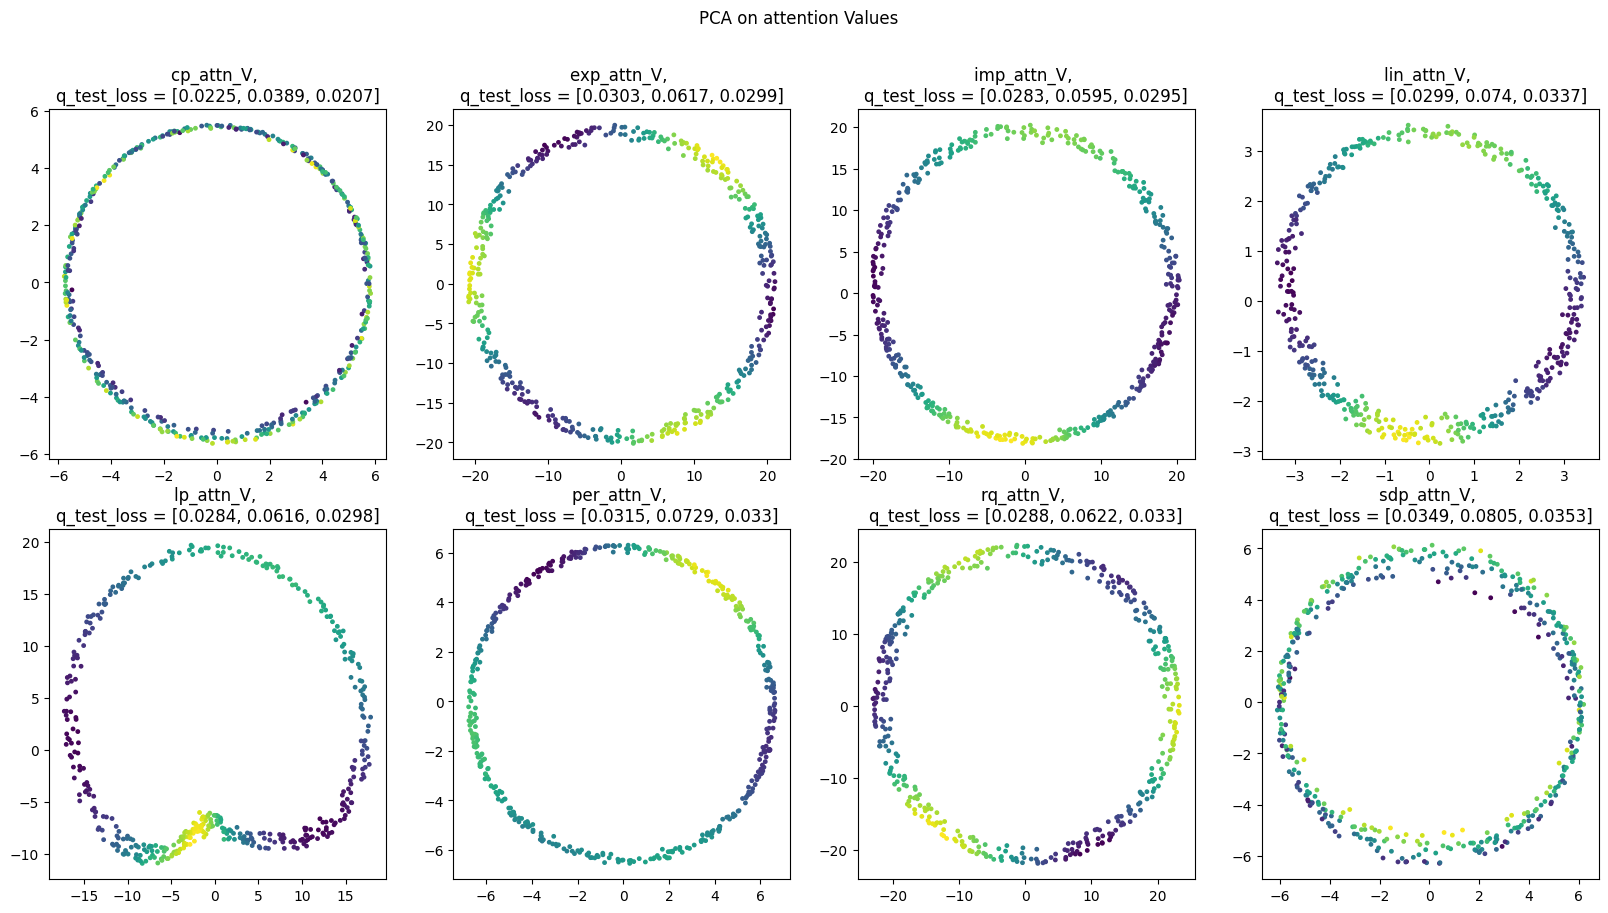

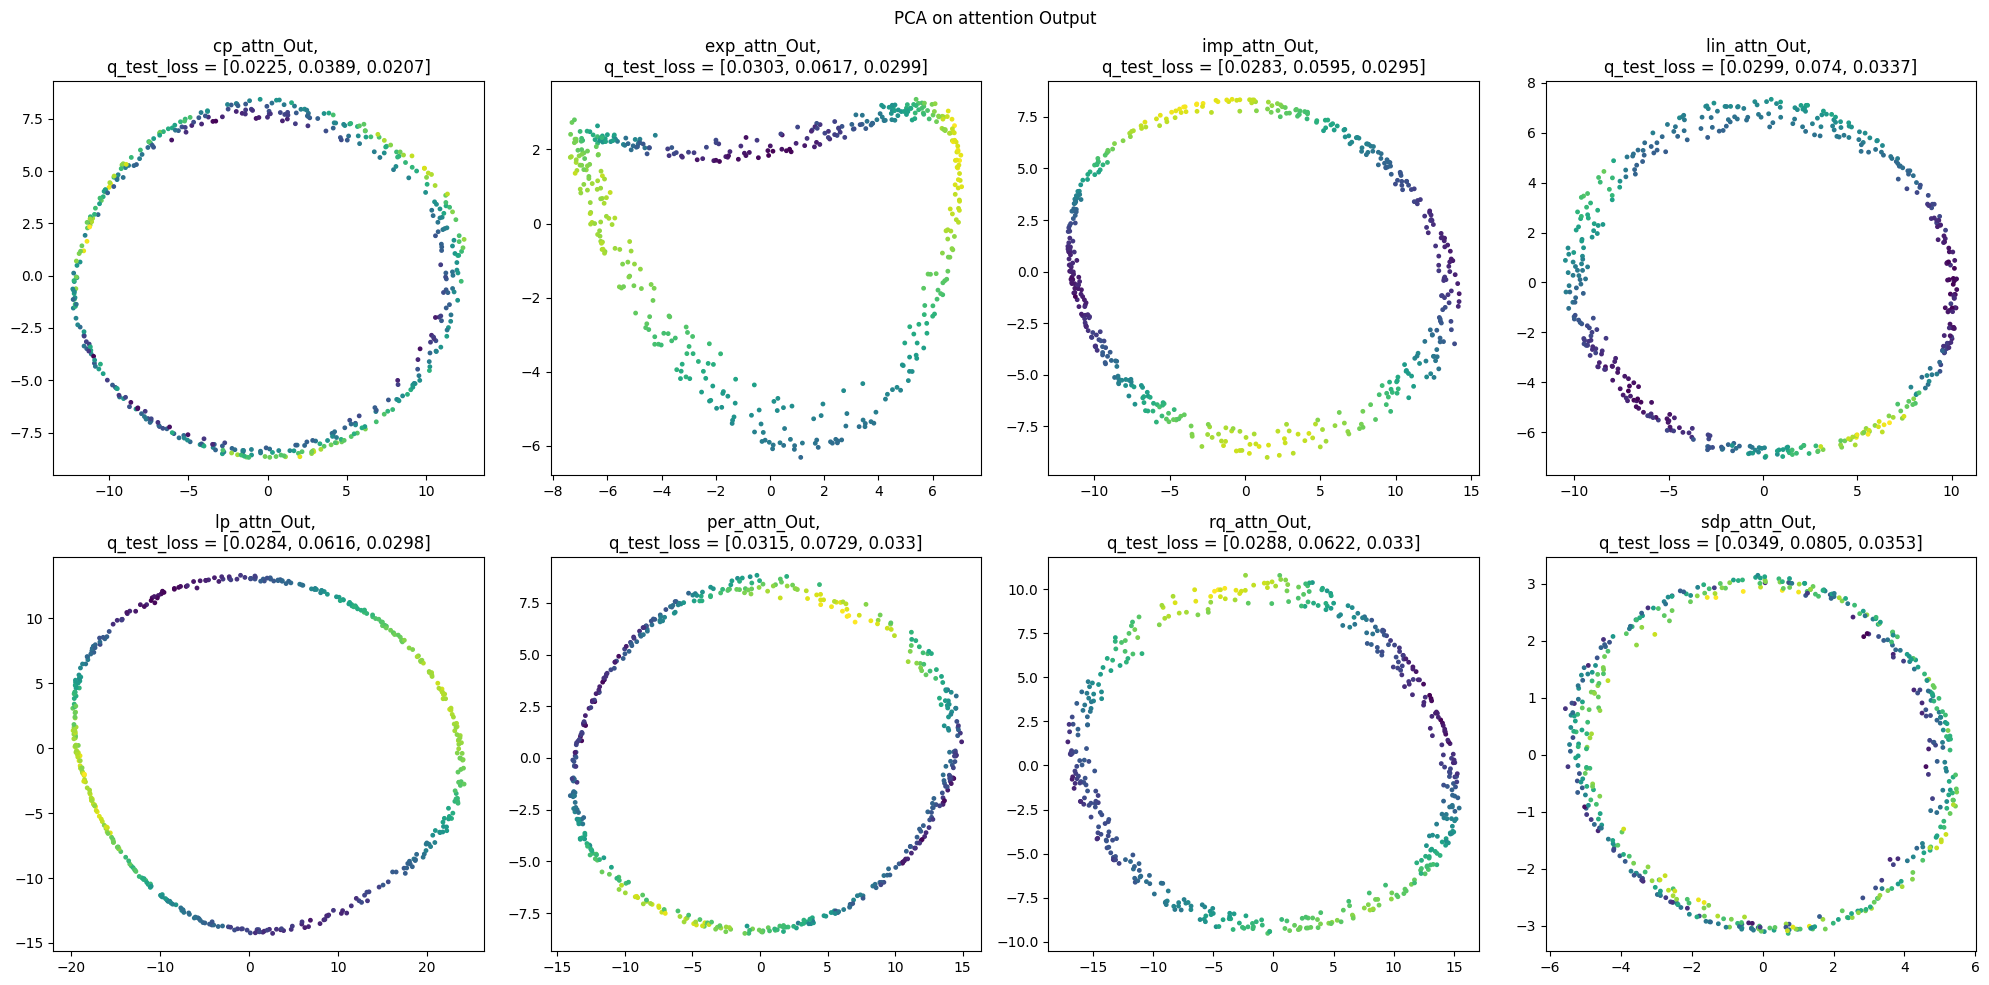

In [51]:
from sklearn.decomposition import PCA
import numpy as np

test_losses = {}

for handle in hook_handles:
    handle.remove()

for key in models.keys():
    
    kernel_model = models[key]
    
    hook_handles.append(kernel_model.pos_enc.register_forward_hook(get_features(f"{key}_pre_attn_emb")))
    hook_handles.append(kernel_model.transformer_blocks[0].mha.W_q.register_forward_hook(get_features(f"{key}_attn_Q")))
    hook_handles.append(kernel_model.transformer_blocks[0].mha.W_k.register_forward_hook(get_features(f"{key}_attn_K")))
    hook_handles.append(kernel_model.transformer_blocks[0].mha.W_v.register_forward_hook(get_features(f"{key}_attn_V")))
    hook_handles.append(kernel_model.transformer_blocks[0].mha.W_o.register_forward_hook(get_features(f"{key}_attn_Out")))
    
    conf = config[key]
    
    criterion = QuantileLoss(conf).to(conf.device)
    
    test_losses[key] = val_step(kernel_model, criterion, test_dl, dataset.mask, conf.device)
    

fig1, axes1 = plt.subplots(2, 4, figsize=(20, 10))
fig1.suptitle(f'PCA on pre attention embeddings')
axes1 = axes1.flatten()
i = 0

fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))
fig2.suptitle(f'PCA on attention Query')
axes2 = axes2.flatten()
j = 0

fig3, axes3 = plt.subplots(2, 4, figsize=(20, 10))
fig3.suptitle(f'PCA on attention Keys')
axes3 = axes3.flatten()
k = 0

fig4, axes4 = plt.subplots(2, 4, figsize=(20, 10))
fig4.suptitle(f'PCA on attention Values')
axes4 = axes4.flatten()
l = 0

fig5, axes5 = plt.subplots(2, 4, figsize=(20, 10))
fig5.suptitle(f'PCA on attention Output')
axes5 = axes5.flatten()
m = 0

for name in features.keys():

    tensors = torch.concat(features[name], dim=0)
    
    flattened = tensors.sum(dim=-1).flatten(start_dim=1)
    
    pca = PCA(n_components=3)
    pca_tensors = pca.fit_transform(flattened.detach().numpy())
    
    #print(pca_tensors.shape, flattened.shape, tensors.shape)
    print(pca.explained_variance_ratio_.cumsum())
    attn_name = name.split('_')[0]
    test_loss = [round(t, 4) for t in test_losses[attn_name].tolist()]
    
    if name.endswith('_pre_attn_emb'):
        axes1[i].set_title(f'{name}, \nq_test_loss = {test_loss}')
        axes1[i].scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
        i += 1
    elif name.endswith('Q'):
        axes2[j].set_title(f'{name}, \nq_test_loss = {test_loss}')
        axes2[j].scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
        j += 1
    elif name.endswith('K'):
        axes3[k].set_title(f'{name}, \nq_test_loss = {test_loss}')
        axes3[k].scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
        k += 1
    elif name.endswith('V'):
        axes4[l].set_title(f'{name}, \nq_test_loss = {test_loss}')
        axes4[l].scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
        l += 1
    elif name.endswith('Out'):
        axes5[m].set_title(f'{name}, \nq_test_loss = {test_loss}')
        axes5[m].scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
        m += 1
    
plt.tight_layout()
plt.show()

# for name in features.keys():
#     
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#     
#     tensors = torch.concat(features[name], dim=0)
#     
#     flattened = tensors.flatten(start_dim=1)
#     
#     pca_tensors = PCA(n_components=3).fit_transform(flattened.detach().numpy().T)
#     
#     ax2.scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=pca_tensors[:, 2], s=6)
#     
#     # pca_tensors = []
#     # median_per_series = []
#     # for tensor in tensors:
#     #     tensor = tensor.squeeze()
#     #     
#     #     pca_tensors.append(PCA(n_components=2).fit_transform(tensor.detach().numpy().T))
#     # 
#     #     median_per_series.append(np.median(tensor.detach().numpy(), axis=0))
#     # 
#     # pca_tensors = np.concatenate(pca_tensors, axis=0)
#     # median_per_series = np.concatenate(median_per_series)
#     # 
#     # 
#     # 
#     # ax2.scatter(pca_tensors[:, 0], pca_tensors[:, 1], c=median_per_series, s=6)
#     # ax2.set_title("PCA per time series")
#     # 
#     # ax1.plot(tensors.mean(dim=2).T)
#     # ax1.set_title(name)
#     
#     
#     
#     plt.tight_layout()
#     plt.show()